In [141]:
from shapely.geometry import Point, Polygon
from descartes import PolygonPatch
from IPython.display import display
from icecream import ic
from math import pi
import matplotlib.pyplot as plt
import pandas as pd
from numpy import array

# pd.set_option('display.precision',2)
pd.set_option('display.float_format','{:,.2f}'.format)


class single_shape:
	def __init__(self,shape,shp_num,full_shape,inertia_type,axis_type):
		self.shape = shape['shape']
		self.shape_type = shape['shape_type']
		self.sign = shape['sign']
		self.inertia_type = inertia_type
		self.full_shape = full_shape
		self.axis_type = axis_type
		self.get_bounds()
		self.get_inertia()

		if self.inertia_type == 'I_y':
			self.df = pd.DataFrame({
				'Name':[shp_num],
				'Sign':[self.sign],
				'x Centroid': [self.shape.centroid.x],
				'Area':[self.shape.area],
				'Parallel axis':[self.p_axis],
				'I_y':[self.inertia],
			})
		if self.inertia_type == 'I_x':
			self.df = pd.DataFrame({
				'Name':[shp_num],
				'Sign':[self.sign],
				'y Centroid': [self.shape.centroid.y],
				'Area':[self.shape.area],
				'Parallel axis':[self.p_axis],
				'I_x':[self.inertia],
			})




	
	def get_bounds(self):
		s = self.shape
		self.x_len = (s.bounds[2] - s.bounds[0])
		self.y_len = (s.bounds[3] - s.bounds[1])


		if self.inertia_type == 'I_y':
			self.b = self.y_len
			self.h = self.x_len
			if self.axis_type == 'axis':
				self.p_axis =  (self.shape.area * (self.shape.centroid.x)**2)
			elif self.axis_type == 'centroid':
				self.p_axis =  (self.shape.area * (self.shape.centroid.x - self.full_shape.centroid.x)**2)
			# 



		elif self.inertia_type == 'I_x':
			self.b = self.x_len
			self.h = self.y_len
			if self.axis_type == 'axis':
				self.p_axis =  (self.shape.area * (self.shape.centroid.y)**2)
			elif self.axis_type == 'centroid':
				self.p_axis =  (self.shape.area * (self.shape.centroid.y - self.full_shape.centroid.y)**2)


			# 
		

	def get_inertia(self):
		if self.shape_type == 'Rectangle':
			self.inertia = (1/12 * self.b * self.h**3) + self.p_axis
		elif self.shape_type == 'Triangle':
			self.inertia = (1/36 * self.b * self.h**3) + self.p_axis
		elif self.shape_type == 'Circle':
			self.inertia = (1/4 * pi * (self.b/2)**4) + self.p_axis

		
		



class full_shape:
	def __init__(self,shapes,inertia_type,axis_type):
		# self.df = pd.DataFrame({'inertia':[],'shape_type':[],'sign':[]})

		for i,shape in enumerate(shapes):
			if i == 0:
				self.shape = shape['shape']
			elif shape['sign'] == '+':
				self.shape = self.shape.union(shape['shape'])
			else:
				self.shape = self.shape.difference(shape['shape'])

		for i,shape in enumerate(shapes):
			c_shape = single_shape(shape,i+1,self.shape,inertia_type,axis_type)
			single_inertia = c_shape.inertia
			# print(f"{i}  {single_inertia:,.2f}")
			if i == 0:
				self.inertia = single_inertia
			elif shape['sign'] == '+':
				self.inertia += single_inertia
			else:
				self.inertia -= single_inertia

			# Dataframe
			if i ==0:
				self.df = c_shape.df
			else:
				self.df = self.df.append(c_shape.df)

		# Df
		if inertia_type == 'I_y':
			self.df = self.df.append(pd.DataFrame({
				'Name':['Total'],
				'Sign':[''],
				'x Centroid': [self.shape.centroid.x],
				'Area':[self.shape.area],
				'Parallel axis':[''],
				'I_y':[self.inertia],
			}))
		if inertia_type == 'I_x':
			self.df = self.df.append(pd.DataFrame({
				'Name':['Total'],
				'Sign':[''],
				'y Centroid': [self.shape.centroid.y],
				'Area':[self.shape.area],
				'Parallel axis':[''],
				'I_x':[self.inertia],
			}))
		self.df.set_index('Name',inplace=True)

		# Plot
		fig,ax = plt.subplots(figsize=(3,3))
		x1,y1,x2,y2 = self.shape.bounds
		xy1 = min(x1,y1)
		xy2 = max(x2,y2)
		ax.set_xlim(xy1,xy2)
		ax.set_ylim(xy1,xy2)
		

		for i,shape in enumerate(shapes):
			S = shape['shape']
			if shape['sign'] == '+':
				ax.add_artist(PolygonPatch(S,facecolor='green',alpha=1))
				ax.text(S.centroid.x,S.centroid.y,f"{i+1}",fontsize=10,bbox=dict(facecolor='green', alpha=1))
			else:
				ax.add_artist(PolygonPatch(S,facecolor='red',alpha=0.3))
				ax.text(S.centroid.x,S.centroid.y,f"{i+1}",fontsize=10,bbox=dict(facecolor='red', alpha=.3))


# Example 1

C:\Users\dnoell\Anaconda3\envs\geo\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


pandas.core.frame.DataFrame

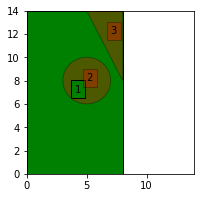

In [146]:
points = [[0,0],
[8,0],
[8,8],
[5,14],
[0,14],]
hole = Point(5,8).buffer(2)
full = Polygon(points)
S1 = full.envelope
S2 = hole
S3 = S1.difference(full)

full = [
	{
		'shape':S1,
		'shape_type':'Rectangle',
		'sign':'+',
		},
	{
		'shape':S2,
		'shape_type':'Circle',
		'sign':'-',
		},
	{
		'shape':S3,
		'shape_type':'Triangle',
		'sign':'-',
		},
]

full_shape(full,"I_y",'centroid').df

# Example 2

C:\Users\dnoell\Anaconda3\envs\geo\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


,Sign,y Centroid,Area,Parallel axis,I_x
Name,,,,,
1,+,500.00,"40,000.00","900,000,000.00","1,433,333,333.33"
2,+,350.00,"40,000.00",0.00,"33,333,333.33"
3,+,200.00,"40,000.00","900,000,000.00","1,433,333,333.33"
Total,,350.00,"120,000.00",,"2,900,000,000.00"


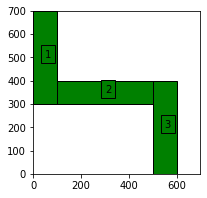

In [143]:
S1 = Polygon([
	[0,700],
	[100,700],
	[100,300],
	[0,300],
	])
S2 = Polygon([
	[100,400],
	[500,400],
	[500,300],
	[100,300],
	])
S3 = Polygon([
	[500,400],
	[600,400],
	[600,0],
	[500,0],
	])

full = [
	{
		'shape':S1,
		'shape_type':'Rectangle',
		'sign':'+',
		},
	{
		'shape':S2,
		'shape_type':'Rectangle',
		'sign':'+',
		},
	{
		'shape':S3,
		'shape_type':'Rectangle',
		'sign':'+',
		},
]

full_shape(full,"I_x",'centroid').df


# full_shape(full,"I_y",'centroid')




C:\Users\dnoell\Anaconda3\envs\geo\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


,Sign,x Centroid,Area,Parallel axis,I_y
Name,,,,,
1,+,4.00,8.00,128.00,170.67
2,+,4.00,6.00,96.00,96.12
3,+,4.00,8.00,128.00,170.67
Total,,4.00,22.00,,437.46


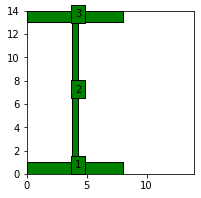

In [144]:
S1 = Polygon([
	[0,0],
	[8,0],
	[8,1],
	[0,1],
	])
S2 = Polygon([
	[3.75,1],
	[4.25,1],
	[4.25,13],
	[3.75,13],
	])
S3 = Polygon([
	[0,13],
	[8,13],
	[8,14],
	[0,14],
	])


shapes = [
	{
		'shape':S1,
		'shape_type':'Rectangle',
		'sign':'+',
		},
	{
		'shape':S2,
		'shape_type':'Rectangle',
		'sign':'+',
		},
	{
		'shape':S3,
		'shape_type':'Rectangle',
		'sign':'+',
		},
]
# full_shape(shapes,"I_x",'axis').df
full_shape(shapes,"I_y",'axis').df


# Example 4

C:\Users\dnoell\Anaconda3\envs\geo\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


,Sign,x Centroid,Area,Parallel axis,I_y
Name,,,,,
1,+,3.00,54.00,486.00,648.00
2,-,3.00,12.55,112.92,125.48
3,-,2.00,9.00,36.00,54.00
4,+,8.00,27.00,"1,728.00","1,782.00"
Total,,5.42,59.45,,"2,250.52"


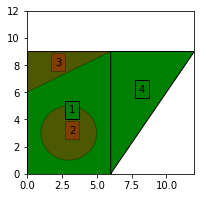

In [145]:
S1 = Polygon([
	[0,0],
	[6,0],
	[6,9],
	[0,9],
	])
S2 = Point(3,3).buffer(2)
S3 = Polygon([
	[0,6],
	[0,9],
	[6,9],
	])
S4 = Polygon([
	[6,0],
	[12,9],
	[6,9],
	])



shapes = [
	{
		'shape':S1,
		'shape_type':'Rectangle',
		'sign':'+',
		},
	{
		'shape':S2,
		'shape_type':'Circle',
		'sign':'-',
		},
	{
		'shape':S3,
		'shape_type':'Triangle',
		'sign':'-',
		},
	{
		'shape':S4,
		'shape_type':'Triangle',
		'sign':'+',
		},
]
# full_shape(shapes,"I_x",'axis')
full_shape(shapes,"I_y",'axis').df
